In [5]:
import torch

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from torch import nn
from torch.autograd.functional import jacobian


torch.manual_seed(0)

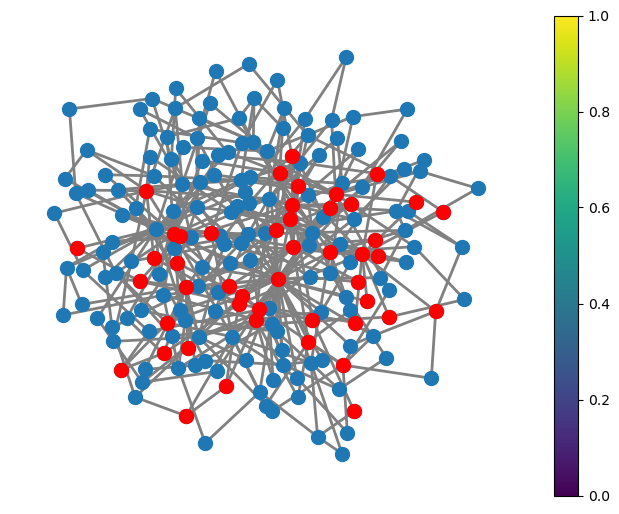

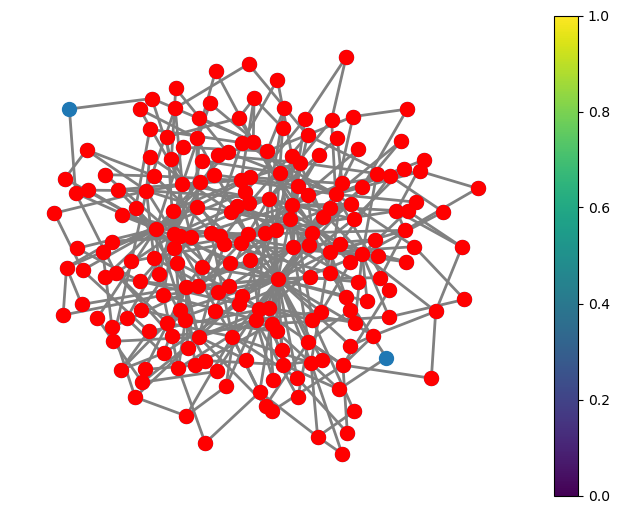

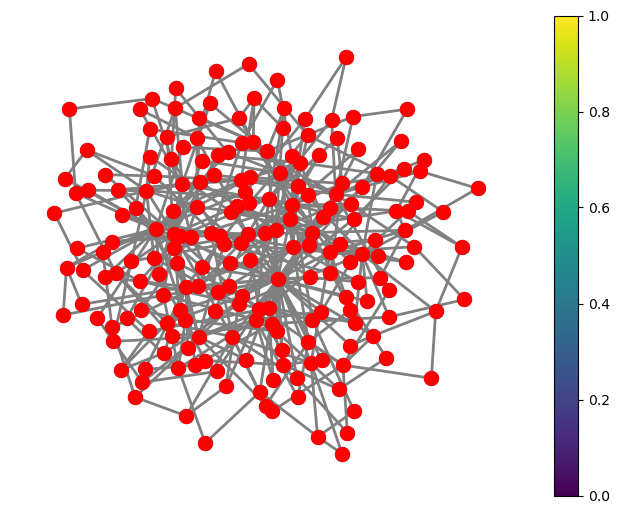

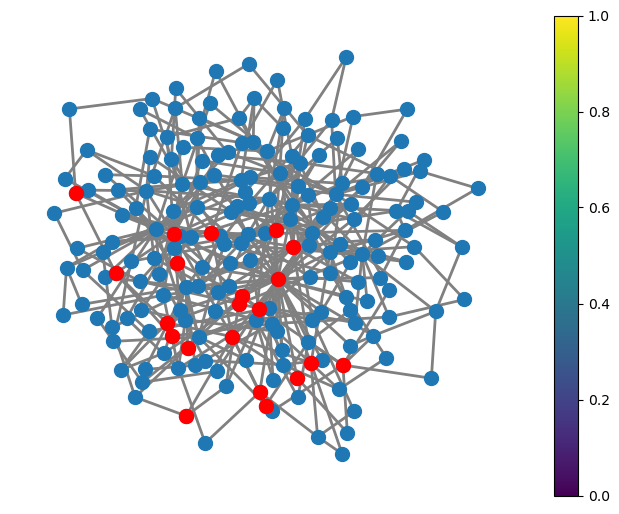

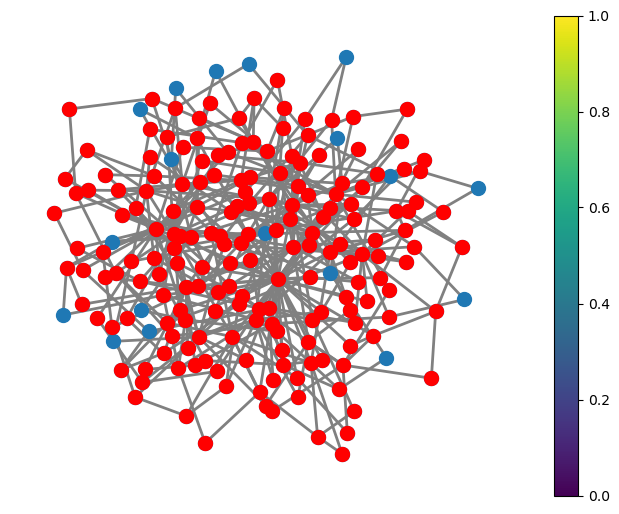

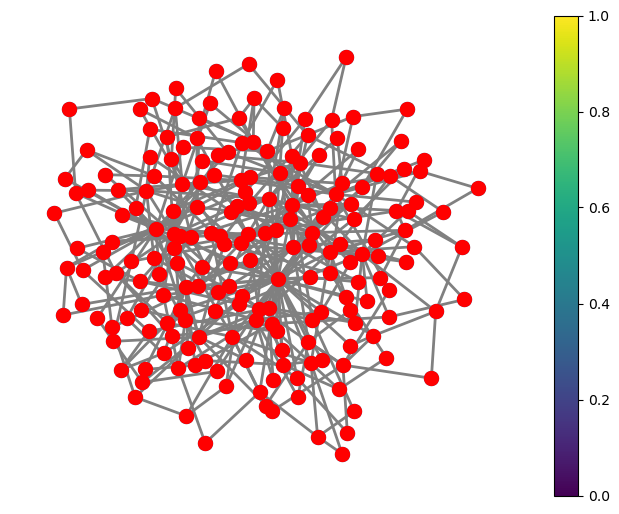

In [51]:
"""
    Effective range
"""
# -- Initialize graph
seed = 32
n_V = 200   # total number of nodes
G = nx.barabasi_albert_graph(n_V, 2, seed=seed)
for i in [17,27]:      # node ID
    for k in [2,4,6]:
        # -- plot graph
        layout = nx.spring_layout(G, seed=seed, iterations=400)
        nx.draw(G, pos=layout, edge_color='gray', width=2, with_labels=False, node_size=100)

        # -- plot neighborhood
        nodes = nx.single_source_shortest_path_length(G, i, cutoff=k)
        im2 = nx.draw_networkx_nodes(G, nodelist=nodes, label=nodes, pos=layout, node_color='red', node_size=100)

        # -- visualize
        plt.colorbar(im2)
        plt.show()
        plt.close()

In [54]:
# adjacency matrix
A = nx.adjacency_matrix(G)
A= torch.from_numpy(A.toarray())
print(A.dtype)

torch.int64


/var/folders/rp/zkw57zfd7t3ghwj9lggcnry40000gn/T/ipykernel_93145/2085707327.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


In [62]:

class GCN:
    """
        Graph convolutional layer
    """
    def __init__(self, in_features, out_features):
        # -- initialize weight
        self.in_features = in_features
        self.out_features = out_features
        self.W = nn.Parameter(torch.DoubleTensor(in_features, out_features))
        nn.init.xavier_normal_(self.W)

        # -- non-linearity
        self.relu = nn.ReLU()

    def __call__(self, A, H):
        # -- GCN propagation rule
        A += torch.eye(A.shape[0], dtype=torch.float64)
        D = torch.diag(1. / torch.sqrt(torch.sum(A, axis=1)))
        # D2 = torch.diag(torch.sqrt(torch.sum(A, axis=1)))
        H = self.relu(D @ A @ D @ H @ self.W)
        return H

# first model with dimension 200-100
class MyModel1(nn.Module):
    """
        model
    """
    def __init__(self, A):
        super(MyModel1, self).__init__()
        # -- initialize layers
        torch.manual_seed(0)
        self.gcn1=GCN(200,100)
        self.A = A

    def forward(self, h0):
        h1 = self.gcn1(self.A,h0)
        return h1

# second model with dimension 200-100-50-20
class MyModel2(nn.Module):
    """
        model
    """
    def __init__(self, A):
        super(MyModel2, self).__init__()
        # -- initialize layers
        torch.manual_seed(0)
        self.gcn1=GCN(200,100)
        self.gcn2=GCN(100,50)
        self.gcn3=GCN(50,20)
        self.A = A

    def forward(self, h0):
        h1 = self.gcn1(self.A,h0)
        h2 = self.gcn2(self.A,h1)
        h3 = self.gcn3(self.A,h2)
        return h3

# third model with dimension 200-100-50-20-20-20
class MyModel3(nn.Module):
    """
        model
    """
    def __init__(self, A):
        super(MyModel3, self).__init__()
        # -- initialize layers
        torch.manual_seed(0)
        self.gcn1=GCN(200,100)
        self.gcn2=GCN(100,50)
        self.gcn3=GCN(50,20)
        self.gcn4=GCN(20,20)
        self.gcn5=GCN(20,20)
        self.A = A

    def forward(self, h0):
        h1 = self.gcn1(self.A,h0)
        h2 = self.gcn2(self.A,h1)
        h3 = self.gcn3(self.A,h2)
        h4 = self.gcn4(self.A,h3)
        h5 = self.gcn5(self.A,h4)
        return h5

In [73]:
"""
    Influence score
"""
# -- Initialize the model and node feature vectors
import torch.nn.functional as F
# inital one hot coding 
H = torch.eye(n_V,dtype=torch.float64)
#initial adjacency matrix
A = nx.adjacency_matrix(G)
A= torch.from_numpy(A.toarray()).to(torch.float64)

# three models we need go through
models = [MyModel1(A),MyModel2(A),MyModel3(A)]
# H = ?
# list for node embedding of three models
Hs = []
# list for jacob
jacobs = []
for model in models:
    Hs.append(model.forward(H))
    jacob= jacobian(model,H)
    jacobs.append(jacob)
for item in Hs:
    print(item.shape)
    

# -- Influence sore
# inf_score = ?

# -- plot influence scores

/var/folders/rp/zkw57zfd7t3ghwj9lggcnry40000gn/T/ipykernel_93145/2469685191.py:9: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


torch.Size([200, 100])
torch.Size([200, 20])
torch.Size([200, 20])


In [131]:
#list for inf_scores
inf_score = []
for jacob in jacobs:
    for i in [17]:
        for j in range(200):
            J = jacob[i,:,:j]
            inf_score.append(torch.sum(J))
a = torch.rand(600)
i=0
# convert the list into a tensor in order to index inf_scores
for item in inf_score:
        a[i] = item
        i+=1
print(a.shape)
print(a[0:200].shape)
print(a[200:400].shape)
print(a[400:600].shape)

torch.Size([600])
torch.Size([200])
torch.Size([200])
torch.Size([200])


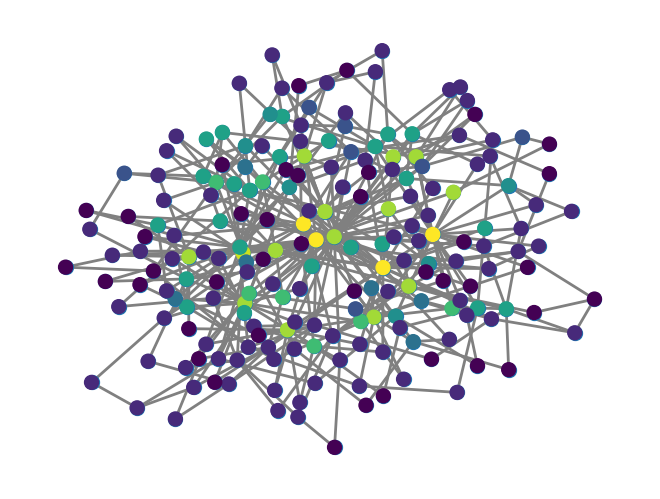

In [132]:
# plot the graph with influ_scores calculated from model1
G = nx.barabasi_albert_graph(n_V, 2, seed=seed)
layout = nx.spring_layout(G, seed=seed, iterations=400)
nx.draw(G, pos=layout, edge_color='gray', width=2, with_labels=False, node_size=100)
nodes = list(range(200))
im2 = nx.draw_networkx_nodes(G, nodelist=nodes, label=nodes, pos=layout, node_color=a[0:200], node_size=100)

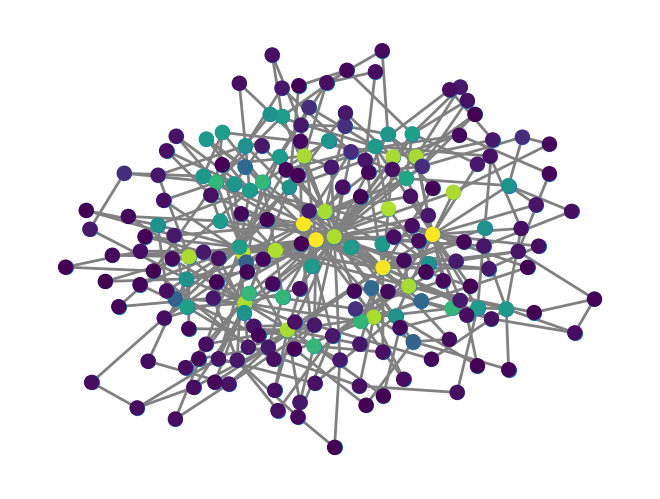

In [133]:
# plot the graph with influ_scores calculated from model2
G = nx.barabasi_albert_graph(n_V, 2, seed=seed)
layout = nx.spring_layout(G, seed=seed, iterations=400)
nx.draw(G, pos=layout, edge_color='gray', width=2, with_labels=False, node_size=100)
nodes = list(range(200))
im2 = nx.draw_networkx_nodes(G, nodelist=nodes, label=nodes, pos=layout, node_color=a[200:400], node_size=100)

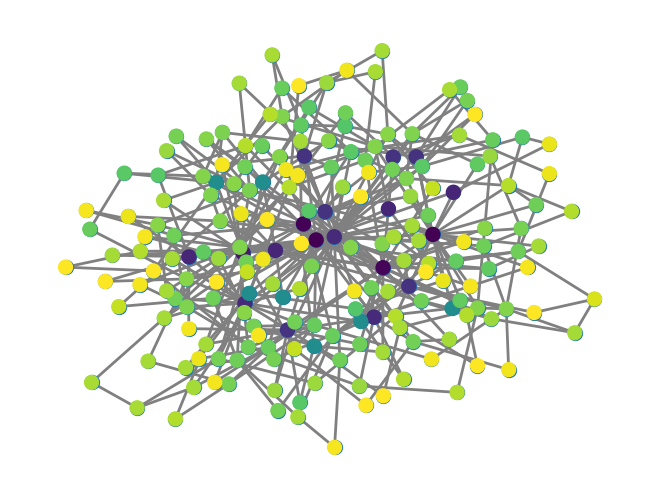

In [134]:
# plot the graph with influ_scores calculated from model3
G = nx.barabasi_albert_graph(n_V, 2, seed=seed)
layout = nx.spring_layout(G, seed=seed, iterations=400)
nx.draw(G, pos=layout, edge_color='gray', width=2, with_labels=False, node_size=100)
nodes = list(range(200))
im2 = nx.draw_networkx_nodes(G, nodelist=nodes, label=nodes, pos=layout, node_color=a[400:600], node_size=100)